In [74]:
# from google.colab import drive
# drive.mount('/content/drive/')

## **ÌïôÏäµ & ÌÖåÏä§Ìä∏ ÌîÑÎ°úÏÑ∏Ïä§ ÏöîÏïΩ**
| Îã®Í≥Ñ | ÌïôÏäµ (Train) | ÌÖåÏä§Ìä∏ (Test) |
|------|------------|-------------|
| **1. Îç∞Ïù¥ÌÑ∞ ÏûÖÎ†•** | CSV ÌååÏùº (Ïù¥ÎØ∏ Ï∂îÏ∂úÎêú ÌäπÏßïÍ∞í) | ÎèôÏòÅÏÉÅ |
| **2. ÌäπÏßï Ï∂îÏ∂ú** | CSVÏóêÏÑú Î∂àÎü¨Ïò§Í∏∞ | ÎèôÏòÅÏÉÅ ‚Üí ÌîÑÎ†àÏûÑ Ï∂îÏ∂ú ‚Üí 12Í∞ú Î¨∂Ïùå ‚Üí ÌäπÏßï Ï∂îÏ∂ú |
| **3. Îç∞Ïù¥ÌÑ∞ Î≥ÄÌôò** | `(Î∞∞Ïπò, 12, 5)` ÌòïÌÉúÎ°ú Î≥ÄÌôò | `(1, 12, 5)` ÌòïÌÉúÎ°ú Î≥ÄÌôò |
| **4. Î™®Îç∏ ÌïôÏäµ/ÏòàÏ∏°** | LSTM Î™®Îç∏ ÌïôÏäµ | LSTM Î™®Îç∏ÏùÑ Ïù¥Ïö©Ìï¥ ÏòàÏ∏° |
| **5. Í≤∞Í≥º Ï†ÄÏû•** | `.pth` ÌååÏùºÎ°ú Ï†ÄÏû• | ÏòàÏ∏°Í∞í Ï∂úÎ†• |


# 1. ÌïôÏäµ

1. Ï∂îÏ∂úÎêú feature Î°úÎìú Î∞è Î≥ëÌï©
2. LSTM Input ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
3. LSTM ÌïôÏäµ

## ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏

In [75]:
# !pip install koreanize-matplotlib

In [76]:
import os
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import koreanize_matplotlib
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torch.autograd import Variable

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

## 1-2. LSTM Input ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò

### Config ÏÑ§Ï†ï

In [77]:
config = {
    # RNN ÏÑ§Ï†ï
    "RNN_hidden_layers": 3,  # LSTM Layer Í∞úÏàò
    "RNN_hidden_nodes": 512,  # RNN Hidden State ÌÅ¨Í∏∞
    "RNN_FC_dim": 256,  # RNN ÏµúÏ¢Ö FC Layer Îâ¥Îü∞ Í∞úÏàò
    "dropout_p": 0.2,  # ÎìúÎ°≠ÏïÑÏõÉ ÎπÑÏú®

    # ÌïôÏäµ ÏÑ§Ï†ï
    "k": 4,  # ÌÅ¥ÎûòÏä§ Í∞úÏàò (normal, yawn, phonecall, text)
    "feature_num": 5, # Pitch, Yaw, EAR, MAR, Phone Detected
    "timestep": 24,
    "sliding_step": 12,
    "epochs": 100,  # Ï¥ù ÌïôÏäµ ÌöüÏàò
    "batch_size": 32,  # Î∞∞Ïπò ÌÅ¨Í∏∞
    "learning_rate": 5e-5,  # ÌïôÏäµÎ•†
    "log_interval": 5,  # Î™á Î≤àÏùò Î∞∞ÏπòÎßàÎã§ Î°úÍ∑∏ Ï∂úÎ†•Ìï†ÏßÄ

    "action_names": ["normal", "phonecall", "text", "yawn"],  # Î∂ÑÎ•òÌï† ÌñâÎèô Î¶¨Ïä§Ìä∏

    "use_cuda": torch.cuda.is_available(),
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),  # GPU ÏÇ¨Ïö© Í∞ÄÎä• Ïó¨Î∂ÄÏóê Îî∞Îùº ÏÑ§Ï†ï
    "early_stopping_patience": 10,  # Early Stopping Í∏∞Ï§Ä Epoch
    "reduce_lr_factor": 0.5,  # Learning Rate Í∞êÏÜå ÎπÑÏú®
    "reduce_lr_patience": 3,  # Learning Rate Í∞êÏÜå Í∏∞Ï§Ä Epoch

    "random_seed": 24,

    # Î™®Îç∏ Í≤∞Í≥º Ï†ÄÏû• Í≤ΩÎ°ú
    "model_save_path": "/content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding",
    "train_result_path": "/content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/train_results",
}

In [78]:
def set_random_seed(seed):
    torch.manual_seed(seed)  # PyTorch CPU Ïó∞ÏÇ∞Ïóê ÎåÄÌïú ÏãúÎìú ÏÑ§Ï†ï
    torch.cuda.manual_seed(seed)  # CUDA Ïó∞ÏÇ∞Ïóê ÎåÄÌïú ÏãúÎìú ÏÑ§Ï†ï (GPU ÏÇ¨Ïö© Ïãú)
    torch.cuda.manual_seed_all(seed)  # Ïó¨Îü¨ GPUÎ•º ÏÇ¨Ïö©ÌïòÎäî Í≤ΩÏö∞ Î™®Îì† GPUÏóê ÎèôÏùºÌïú ÏãúÎìú ÏÑ§Ï†ï
    np.random.seed(seed)  # NumPy Ïó∞ÏÇ∞Ïóê ÎåÄÌïú ÏãúÎìú ÏÑ§Ï†ï
    random.seed(seed)  # Python Í∏∞Î≥∏ random Î™®ÎìàÏùò ÏãúÎìú ÏÑ§Ï†ï
    torch.backends.cudnn.deterministic = True  # CuDNN Ïó∞ÏÇ∞Ïùò Í≤∞Ï†ïÎ°†Ï†Å ÎèôÏûë Î≥¥Ïû•
    torch.backends.cudnn.benchmark = False  # ÏÑ±Îä• ÏµúÏ†ÅÌôî ÎπÑÌôúÏÑ±Ìôî (Ïû¨ÌòÑÏÑ± Î≥¥Ïû•)

In [79]:
set_random_seed(config["random_seed"])

## Îç∞Ïù¥ÌÑ∞ Î°úÎìú

### process_features

In [80]:
# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞
BATCH_SIZE = config['batch_size']
TIMESTEP = config['timestep']
FEATURE_DIM = config['feature_num'] # Pitch, Yaw, EAR, MAR, Phone Detected
NUM_CLASSES = config['k']  # normal, phonecall, text, yawn
SLIDING_STEP = config['sliding_step']
label_mapping = {"normal": 0, "phonecall": 1, "text": 2, "yawn": 3}
label_mapping_inverse = {0: "normal", 1: "phonecall", 2: "text", 3: "yawn"}

# Í≥µÌÜµ Î°úÏßÅ: Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï≤òÎ¶¨ Î∞è ÏãúÌÄÄÏä§ ÏÉùÏÑ±
def process_features(df, sliding_labels=None, yaw_inversion_labels=None, is_train=True):
    """
    Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú ÏãúÌÄÄÏä§Î•º ÏÉùÏÑ±ÌïòÎäî Ìï®Ïàò.

    Args:
        df (pd.DataFrame): ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ.
        sliding_labels (list): Sliding window Î∞©Ïãù Ï†ÅÏö©Ìï† ÎùºÎ≤® Î¶¨Ïä§Ìä∏ (Ïòà: ['text', 'yawn']).
        is_train (bool): ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ Ïó¨Î∂Ä. ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Îäî sliding stepÏùÑ ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏùå.

    Returns:
        torch.Tensor: ÏãúÌÄÄÏä§ Îç∞Ïù¥ÌÑ∞.
        torch.Tensor: ÎùºÎ≤® Îç∞Ïù¥ÌÑ∞.
        list: Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ (label, group_key, sequence_index).
        np.array: StratifiedGroupkFold ÏûÖÎ†•Ïö© person ids
    """
    # label Ïù∏ÏΩîÎî©
    df['label_encoded'] = df['label'].map(label_mapping)

    sequences = []
    labels = []
    person_ids = [] # cv Ïö©
    metadata = []  # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ï†ÄÏû• Î¶¨Ïä§Ìä∏

    for (label_encoded, group_key), group in df.groupby(['label_encoded', 'video_clip']):
        group = group.sort_values(by='frame')  # ÌîÑÎ†àÏûÑ ÏàúÏÑúÎåÄÎ°ú Ï†ïÎ†¨
        features = group[["gaze_pitch", "gaze_yaw", "EAR", "MAR", "phone_detected"]].values
        person_id = group_key.split("_")[0]

        # Sliding window Î∞©Ïãù Ï†ÅÏö© Ïó¨Î∂Ä Í≤∞Ï†ï
        if is_train and sliding_labels and label_mapping_inverse[label_encoded] in sliding_labels:
            step_size = SLIDING_STEP
        else:
            step_size = TIMESTEP

        # ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Î•º Ï≤òÎ¶¨
        for start_idx in range(0, len(features) - TIMESTEP + 1, step_size):
            end_idx = start_idx + TIMESTEP
            if end_idx <= len(features):
                sequences.append(features[start_idx:end_idx])
                labels.append(label_encoded)
                person_ids.append(person_id)
                metadata.append((label_encoded, group_key, start_idx))  # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ï∂îÍ∞Ä

        # yaw_inversion_labels Ìï¥Îãπ
        if is_train and yaw_inversion_labels and label_mapping_inverse[label_encoded] in yaw_inversion_labels:
            inverted_features = features.copy()
            inverted_features[:, 1] = -inverted_features[:, 1]  # gaze_yaw Î∞òÏ†Ñ 1Î≤àÏß∏ Ïª¨Îüº
            for start_idx in range(0, len(inverted_features) - TIMESTEP + 1, step_size):
                end_idx = start_idx + TIMESTEP
                if end_idx <= len(inverted_features):  # ÎßàÏßÄÎßâ ÏãúÌÄÄÏä§Í∞Ä seq_lengthÏóê ÎßûÎäî Í≤ΩÏö∞Îßå Ï≤òÎ¶¨
                    sequences.append(inverted_features[start_idx:end_idx])
                    labels.append(label_encoded)
                    person_ids.append(person_id)
                    metadata.append((label_encoded, group_key, start_idx))  # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ï∂îÍ∞Ä

    # pytorch tensor Î≥ÄÌôò
    return (torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.long), metadata, np.array(person_ids))


# ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ìï®Ïàò
def load_train_features(df):
    """
    ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞Î•º Ï≤òÎ¶¨ÌïòÏó¨ ÏãúÌÄÄÏä§Î•º ÏÉùÏÑ±ÌïòÎäî Ìï®Ïàò.
    """
    sliding_labels = ['yawn']  # Sliding window Î∞©Ïãù Ï†ÅÏö©Ìï† ÎùºÎ≤® Î¶¨Ïä§Ìä∏
    yaw_inversion_labels = ['text', 'yawn']
    return process_features(df, sliding_labels=sliding_labels, yaw_inversion_labels=yaw_inversion_labels, is_train=True)

# ÌÖåÏä§Ìä∏Ïö© Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ìï®Ïàò
def load_test_features(df):
    """
    ÌÖåÏä§Ìä∏Ïö© Îç∞Ïù¥ÌÑ∞Î•º Ï≤òÎ¶¨ÌïòÏó¨ ÏãúÌÄÄÏä§Î•º ÏÉùÏÑ±ÌïòÎäî Ìï®Ïàò.
    """
    return process_features(df, sliding_labels=None, is_train=False)

### train, text data load

In [81]:
train = pd.read_csv("/content/drive/MyDrive/DMS/data/EDA/train_processed.csv")
test = pd.read_csv("/content/drive/MyDrive/DMS/data/EDA/test_processed.csv")

In [82]:
train_count = train.groupby('label')['label'].count().reset_index(name='frame_count')
train_count['clip_count'] = train_count['frame_count'] // config['timestep']
print("-----------Train-----------")
display(train_count)
print("-----------Test-----------")
test_count = test.groupby('label')['label'].count().reset_index(name='frame_count')
test_count['clip_count'] = test_count['frame_count'] // config['timestep']
display(test_count)

-----------Train-----------


label  frame_count  clip_count
0     normal        65196        2716
1  phonecall        25296        1054
2       text        10044         418
3       yawn         4404         183

-----------Test-----------


label  frame_count  clip_count
0     normal        14100         587
1  phonecall         5688         237
2       text         2568         107
3       yawn         1212          50

In [83]:
sort_key = ["label", "video_name", "frame", "video_clip"]
features = ["gaze_pitch", "gaze_yaw", "EAR", "MAR", "phone_detected"]
train = train[sort_key + features]
test = test[sort_key + features]

### trainÏóêÏÑú normal 1, 2 Îßå ÏÑ†ÌÉù

In [84]:
print(f"before filtering normal: {len(train)}")
train = train[
    ((train['label'] == 'normal') &
     ((train['video_name'].str.split('_').str[-1] == 'part1') |
      (train['video_name'].str.split('_').str[-1] == 'part2'))) |
    (train['label'] != 'normal')
]
display(train.head())
print(f"after filtering normal: {len(train)}")

before filtering normal: 104940


label                                         video_name            frame  \
0  normal  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...  frame000000.jpg   
1  normal  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...  frame000001.jpg   
2  normal  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...  frame000002.jpg   
3  normal  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...  frame000003.jpg   
4  normal  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...  frame000004.jpg   

                                          video_clip  gaze_pitch  gaze_yaw  \
0  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...   -0.802380 -0.178544   
1  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...   -0.258022 -0.444779   
2  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...    0.173530 -0.746606   
3  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...   -0.022168 -0.725515   
4  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...   -0.187156 -0.672688   

        EAR       MAR  phone_detected  
0  0.188577  0.152621               0  
1  0.115461  0.098821               0  
2  0.101308  0.080448               0  
3  0.101270  0.099019               0  
4  0.110530  0.118148               0

after filtering normal: 71592


In [85]:
train.dropna(inplace=True)
test.dropna(inplace=True)
print("ÌïôÏäµ Îç∞Ïù¥ÌÑ∞: ", train.shape)
print("ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: ", test.shape)

ÌïôÏäµ Îç∞Ïù¥ÌÑ∞:  (71520, 9)
ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞:  (23544, 9)


In [86]:
train_count = train.groupby('label')['label'].count().reset_index(name='frame_count')
train_count['clip_count'] = train_count['frame_count'] // 12
train_count['ratio'] = round(train_count['clip_count'] / train_count['clip_count'].sum() * 100, 1) # ÎπÑÏú® Í≥ÑÏÇ∞
print("-----------Train-----------")
display(train_count)

print("-----------Test-----------")
test_count = test.groupby('label')['label'].count().reset_index(name='frame_count')
test_count['clip_count'] = test_count['frame_count'] // 12
test_count['ratio'] = round(test_count['clip_count'] / test_count['clip_count'].sum() * 100, 1) # ÎπÑÏú® Í≥ÑÏÇ∞
display(test_count)

-----------Train-----------


label  frame_count  clip_count  ratio
0     normal        31800        2650   44.5
1  phonecall        25272        2106   35.3
2       text        10044         837   14.0
3       yawn         4404         367    6.2

-----------Test-----------


label  frame_count  clip_count  ratio
0     normal        14100        1175   59.9
1  phonecall         5664         472   24.1
2       text         2568         214   10.9
3       yawn         1212         101    5.1

In [87]:
# Train, Test dataset
train_features, train_labels, train_meta, train_personids = load_train_features(train)
test_features, test_labels, test_meta, test_personids = load_test_features(test)

In [88]:
# Î†àÏù¥Î∏î Í∞úÏàò Î∞è ÎπÑÏú® Í≥ÑÏÇ∞
label_counts = pd.Series(train_labels).value_counts()
label_ratios = pd.Series(train_labels).value_counts(normalize=True) * 100  # ÎπÑÏú® Í≥ÑÏÇ∞ (Î∞±Î∂ÑÏú®)

# Îß§ÌïëÎêú Í≤∞Í≥º Ï∂úÎ†•
print("Î†àÏù¥Î∏î Î∂ÑÌè¨:")
print("-----------Train-----------")
for label, count in label_counts.items():
    print(f"{label_mapping_inverse[label]}: {count}Í∞ú ({label_ratios[label]:.2f}%)")

# Î†àÏù¥Î∏î Í∞úÏàò Î∞è ÎπÑÏú® Í≥ÑÏÇ∞
label_counts = pd.Series(test_labels).value_counts()
label_ratios = pd.Series(test_labels).value_counts(normalize=True) * 100  # ÎπÑÏú® Í≥ÑÏÇ∞ (Î∞±Î∂ÑÏú®)

print("-----------Test-----------")
for label, count in label_counts.items():
    print(f"{label_mapping_inverse[label]}: {count}Í∞ú ({label_ratios[label]:.2f}%)")

Î†àÏù¥Î∏î Î∂ÑÌè¨:
-----------Train-----------
normal: 1129Í∞ú (33.66%)
phonecall: 1015Í∞ú (30.26%)
text: 780Í∞ú (23.26%)
yawn: 430Í∞ú (12.82%)
-----------Test-----------
normal: 493Í∞ú (57.59%)
phonecall: 229Í∞ú (26.75%)
text: 96Í∞ú (11.21%)
yawn: 38Í∞ú (4.44%)


### Îç∞Ïù¥ÌÑ∞ ÎëòÎü¨Î≥¥Í∏∞ - ÏãúÍ∞ÅÌôî
- ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Í∞úÏàò
- ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò
- ÌÉÄÍ≤üÍ∞í Î∂ÑÌè¨

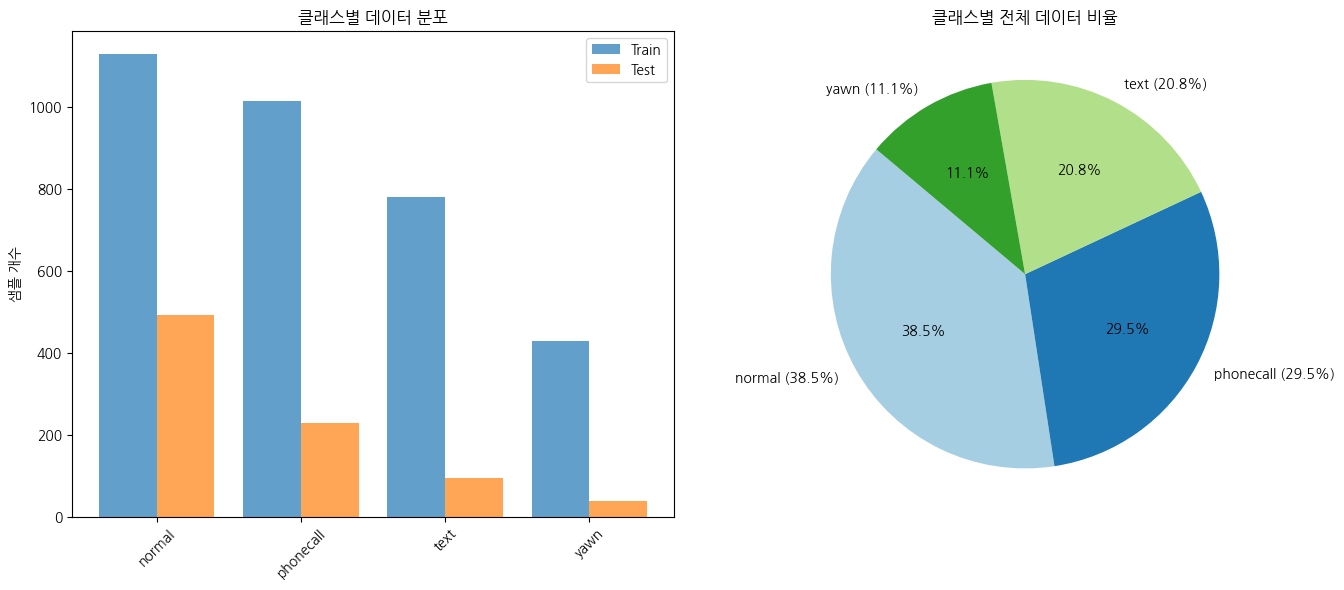

In [89]:
def visualize_data_distribution(train_labels, test_labels, label_mapping_inverse):
    """
    ÌõàÎ†®/ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò Î†àÏù¥Î∏î Î∂ÑÌè¨Î•º ÏãúÍ∞ÅÌôîÌïòÎäî Ìï®Ïàò.

    Args:
        train_labels (list or pd.Series): ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Ïùò Î†àÏù¥Î∏î.
        test_labels (list or pd.Series): ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò Î†àÏù¥Î∏î.
        label_mapping_inverse (dict): Ï†ïÏàòÌòï Î†àÏù¥Î∏îÏùÑ Î¨∏ÏûêÏó¥Î°ú Îß§ÌïëÌïòÎäî ÎîïÏÖîÎÑàÎ¶¨.
    """
    # Î†àÏù¥Î∏î Í∞úÏàò Î∞è ÎπÑÏú® Í≥ÑÏÇ∞
    train_label_counts = pd.Series(train_labels).value_counts()
    train_label_ratios = pd.Series(train_labels).value_counts(normalize=True) * 100

    test_label_counts = pd.Series(test_labels).value_counts()
    test_label_ratios = pd.Series(test_labels).value_counts(normalize=True) * 100

    # ÌÅ¥ÎûòÏä§ Ïù¥Î¶Ñ Îß§Ìïë
    class_names = [label_mapping_inverse[label] for label in train_label_counts.index]

    # ÏãúÍ∞ÅÌôî
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # (ÏôºÏ™Ω) Bar Chart - ÌÅ¥ÎûòÏä§Î≥Ñ ÏÉòÌîå Í∞úÏàò ÎπÑÍµê
    x = np.arange(len(class_names))
    width = 0.4

    axes[0].bar(x - width / 2, train_label_counts.values, width, label="Train", alpha=0.7)
    axes[0].bar(x + width / 2, test_label_counts.values, width, label="Test", alpha=0.7)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(class_names, rotation=45)
    axes[0].set_ylabel("ÏÉòÌîå Í∞úÏàò")
    axes[0].set_title("ÌÅ¥ÎûòÏä§Î≥Ñ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌè¨")
    axes[0].legend()

    # (Ïò§Î•∏Ï™Ω) Pie Chart - Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÎπÑÏú®
    total_counts = train_label_counts + test_label_counts
    total_ratios = total_counts / total_counts.sum() * 100

    axes[1].pie(
        total_counts,
        labels=[f"{class_names[i]} ({total_ratios[i]:.1f}%)" for i in range(len(class_names))],
        autopct="%1.1f%%",
        startangle=140,
        colors=plt.cm.Paired.colors,
    )
    axes[1].set_title("ÌÅ¥ÎûòÏä§Î≥Ñ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÎπÑÏú®")

    plt.tight_layout()
    plt.show()

visualize_data_distribution(train_labels, test_labels, label_mapping_inverse)

### DataLoader

In [90]:
# DataLoader ÏÑ§Ï†ï
params = {
    "batch_size": config["batch_size"],
    "shuffle": True,
    "num_workers": 4,
    "pin_memory": True,
    "persistent_workers": True,
    "prefetch_factor": 2,
} if config["use_cuda"] else {}

In [91]:
# DataLoader ÏÉùÏÑ± (Î∞∞Ïπò Îã®ÏúÑÎ°ú Îç∞Ïù¥ÌÑ∞Î•º ÎÇòÎàÑÍ∏∞ ÏúÑÌï¥ ÏÇ¨Ïö©)
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

train_loader = DataLoader(train_dataset, **params)
test_loader = DataLoader(test_dataset, **params)

# Î∞∞Ïπò Îã®ÏúÑ ÌôïÏù∏
for x_batch, y_batch in train_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # Ìïú Î∞∞ÏπòÎßå ÌôïÏù∏

for x_batch, y_batch in test_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # Ìïú Î∞∞ÏπòÎßå ÌôïÏù∏

Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])


## 1-3. LSTM ÌïôÏäµ

In [92]:
# LSTM Î™®Îç∏ Ï†ïÏùò
class DecoderRNN(nn.Module):
    def __init__(self, config):
        super(DecoderRNN, self).__init__()

        self.RNN_input_size = config['feature_num']  # ÌäπÏßï Í∞úÏàò
        self.h_RNN_layers = config["RNN_hidden_layers"]
        self.h_RNN = config["RNN_hidden_nodes"]
        self.h_FC_dim = config["RNN_FC_dim"]
        self.drop_p = config["dropout_p"]
        self.num_classes = config["k"]

        self.LSTM = nn.LSTM(
            input_size=self.RNN_input_size,
            hidden_size=self.h_RNN,
            num_layers=self.h_RNN_layers,
            batch_first=True,
        )

        self.fc1 = nn.Linear(self.h_RNN, self.h_FC_dim)
        self.fc2 = nn.Linear(self.h_FC_dim, self.num_classes)
        self.dropout = nn.Dropout(p=self.drop_p)

    def forward(self, x_RNN):
        self.LSTM.flatten_parameters()
        RNN_out, _ = self.LSTM(x_RNN, None)

        # FC layers
        x = self.fc1(RNN_out[:, -1, :])  # ÎßàÏßÄÎßâ ÌÉÄÏûÑÏä§ÌÖùa ÏÇ¨Ïö©
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x  # CrossEntropyLoss ÏÇ¨Ïö© (Softmax ÏóÜÏùå)

### optimizer

In [93]:
def get_optimizer(model, config):
    return optim.Adam(model.parameters(), lr=config["learning_rate"])
criterion = nn.CrossEntropyLoss()

### ÌïôÏäµÎ•† Í∞êÏÜå Ïä§ÏºÄÏ§ÑÎü¨ ÏÑ§Ï†ï
Test Loss Í∏∞Ï§Ä
- factor: 0.5, ÌïôÏäµÎ•† 50% Í∞êÏÜå
- verbose: True, Í∞êÏÜåÎêú Í≤ΩÏö∞ Î°úÍ∑∏ Ï∂úÎ†•

In [94]:
def get_scheduler(optimizer, config):
    return optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=config["reduce_lr_factor"],
        patience=config["reduce_lr_patience"],
    )

### Early Stopping ÏÑ§Ï†ï

In [95]:
early_stopping_patience = config["early_stopping_patience"]
best_loss = np.inf
patience_counter = 0

## ÌïôÏäµ ÏßÑÌñâ

- Mixed Precision Training Ïú†ÏßÄ (torch.cuda.amp.autocast() + GradScaler())
-  Gradient Clipping Ï∂îÍ∞Ä (torch.nn.utils.clip_grad_norm_()) ‚Üí Ìè≠Î∞úÏ†ÅÏù∏ Í∏∞Ïö∏Í∏∞(Gradient Explosion) Î∞©ÏßÄ
- Î™®Îç∏ Ï†ÄÏû• Í∏∞Îä• Ï∂îÍ∞Ä (torch.save()) ‚Üí Best Loss Í∞±Ïã† Ïãú ÏûêÎèô Ï†ÄÏû•
- ÌïôÏäµÎ•† Ïä§ÏºÄÏ§ÑÎü¨ Î°úÍπÖ Ï∂îÍ∞Ä ‚Üí ReduceLROnPlateauÍ∞Ä ÏûëÎèôÌñàÎäîÏßÄ ÌôïÏù∏ Í∞ÄÎä•

In [96]:
def save_best_model(model, optimizer, epoch, best_loss, save_path):
    """Validation LossÍ∞Ä Í∞ÄÏû• ÎÇÆÏùÑ ÎïåÎßå Î™®Îç∏ÏùÑ Ï†ÄÏû•ÌïòÎäî Ìï®Ïàò"""
    today_date = datetime.datetime.now().strftime("%Y-%m-%d")  # ÎÇ†Ïßú Í∞ÄÏ†∏Ïò§Í∏∞
    model_filename = f"{save_path}/best_model_{today_date}.pth"  # Ï†ÄÏû• ÌååÏùºÎ™Ö

    # Í∏∞Ï°¥ ÏµúÏ†Å Î™®Îç∏ ÏÇ≠Ï†ú (Ïù¥Ï†Ñ Î™®Îç∏ Ïú†ÏßÄ Ïïà Ìï®)
    if os.path.exists(model_filename):
        os.remove(model_filename)

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss
    }, model_filename)

    print(f"üíæ Best Model Updated! Saved at {model_filename} (Loss: {best_loss:.4f})")

def save_training_results(
        epoch_train_losses,
        epoch_train_scores,
        epoch_test_losses,
        epoch_test_scores,
        save_path="./",
        ):
    """
    ÌïôÏäµ Í≥ºÏ†ïÏùò ÏÜêÏã§(loss)Í≥º Ï†ïÌôïÎèÑ(score)Î•º Ï†ÄÏû•ÌïòÎäî Ìï®Ïàò
    """
    os.makedirs(save_path, exist_ok=True)

    np.save(
        os.path.join(save_path, "LSTM_epoch_training_losses.npy"),
        np.array(epoch_train_losses),
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_tsave_path, raining_scores.npy"),
        np.array(epoch_train_scores),
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_test_loss.npy"), np.array(epoch_test_losses)
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_test_score.npy"),
        np.array(epoch_test_scores),
    )

### epochÎßàÎã§ validation dataÎ°ú ÏÑ±Îä•ÌèâÍ∞Ä
- Îã§Ïùå Í∏∞Ïà†ÏùÑ Ï†ÅÏö©ÌïòÎäî Í∏∞Ï§Ä: Validation data Loss
    - Early Stopping
    - ÌïôÏäµÎ•† Í∞êÏÜå Ïä§ÏºÄÏ§ÑÎü¨
    - Î™®Îç∏ Ï†ÄÏû• (Best Loss Í∞±Ïã† Ïãú)

In [97]:
def ensure_directory_exists(path):
    """Ï£ºÏñ¥ÏßÑ Í≤ΩÎ°úÏùò Ìè¥ÎçîÍ∞Ä ÏóÜÏúºÎ©¥ ÏÉùÏÑ±ÌïòÎäî Ìï®Ïàò"""
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"üìÇ Directory created: {path}")

In [98]:
# ‚úÖ Í≤ΩÎ°ú ÏûêÎèô ÏÉùÏÑ± (Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏúºÎ©¥ ÏÉùÏÑ±)
ensure_directory_exists(os.path.dirname(config["model_save_path"]))  # Î™®Îç∏ Ï†ÄÏû• Ìè¥Îçî
ensure_directory_exists(config["train_result_path"])  # ÌïôÏäµ Í≤∞Í≥º Ìè¥Îçî

In [99]:
# Mixed Precision TrainingÏùÑ ÏúÑÌïú GradScaler ÏÑ§Ï†ï
scaler = torch.amp.GradScaler()

def train_model(model, train_loader, optimizer, criterion, scheduler, config):
    """
    Mixed Precision Training & Early Stopping Ï†ÅÏö© ÌïôÏäµ Ìï®Ïàò
    """
    model.to(config["device"])

    best_loss = np.inf  # Best Loss Ï¥àÍ∏∞Ìôî
    patience_counter = 0  # Early Stopping Ïπ¥Ïö¥ÌÑ∞
    epoch_losses, epoch_scores = [], []  # Loss Î∞è Accuracy Ï†ÄÏû•Ïö© Î¶¨Ïä§Ìä∏

    for epoch in range(config["epochs"]):
        model.train()
        losses, scores = [], []
        total_samples = 0

        # tqdmÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÌïôÏäµ ÏßÑÌñâÎ•† ÌëúÏãú
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}", leave=True)

        for batch_idx, (X, y) in enumerate(progress_bar):
            X, y = X.to(config["device"]), y.to(config["device"]).long()

            # Mixed Precision Training Ï†ÅÏö©
            total_samples += X.size(0)
            optimizer.zero_grad(set_to_none=True)

            with torch.amp.autocast('cuda'): # ÏûêÎèô Mixed Precision ÏÇ¨Ïö©
                output = model(X)  # LSTM Î™®Îç∏ Forward Pass
                loss = criterion(output, y)

            scaler.scale(loss).backward()  # Mixed Precision Backpropagation
            scaler.step(optimizer)  # ÏòµÌã∞ÎßàÏù¥Ï†Ä ÏóÖÎç∞Ïù¥Ìä∏
            scaler.update()  # Scaler ÏóÖÎç∞Ïù¥Ìä∏

            losses.append(loss.item())

            # Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
            y_pred = torch.argmax(output, dim=1)
            acc = accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())
            scores.append(acc)

        avg_loss = sum(losses) / len(losses)
        avg_acc = sum(scores) / len(scores) * 100

        print(f"‚úÖ Epoch {epoch+1} Finished - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.2f}%")

        # Loss Î∞è Accuracy Ï†ÄÏû•
        epoch_losses.append(avg_loss)
        epoch_scores.append(avg_acc)

        # ÌïôÏäµÎ•† Í∞êÏÜå Ïä§ÏºÄÏ§ÑÎü¨ ÏóÖÎç∞Ïù¥Ìä∏ (`ReduceLROnPlateau` ÏÇ¨Ïö© Ïãú `min` Î™®Îìú Ï†ÅÏö©)
        scheduler.step(avg_loss)
        if optimizer.param_groups[0]["lr"] != config["learning_rate"]:
            print(f"üìâ Learning Rate Reduced: {optimizer.param_groups[0]['lr']:.6e}")

        # Î™®Îç∏ Ï†ÄÏû• (Best Loss Í∞±Ïã† Ïãú)
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0  # Early Stopping Counter Ï¥àÍ∏∞Ìôî
            save_best_model(model, optimizer, epoch, best_loss, config["model_save_path"])
            print(f"üíæ Model Saved! New Best Loss: {best_loss:.4f}")
        else:
            patience_counter += 1

        # Early Stopping Ï≤¥ÌÅ¨
        if patience_counter >= config["early_stopping_patience"]:
            print(f"üö® Early Stopping Triggered! Best Loss: {best_loss:.4f}")
            break

    return epoch_losses, epoch_scores

In [100]:
device = config["device"]

model = DecoderRNN(config)
model.to(device)  # Î™®Îç∏ÏùÑ GPUÎ°ú Ïù¥Îèô

optimizer = get_optimizer(model, config)
scheduler = get_scheduler(optimizer, config)

epoch_losses, epoch_scores = train_model(model, train_loader, optimizer, criterion, scheduler, config)

Epoch 1/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 54.43it/s]


‚úÖ Epoch 1 Finished - Avg Loss: 1.2576, Avg Acc: 41.28%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 1.2576)
üíæ Model Saved! New Best Loss: 1.2576


Epoch 2/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 57.84it/s]


‚úÖ Epoch 2 Finished - Avg Loss: 1.0002, Avg Acc: 56.00%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 1.0002)
üíæ Model Saved! New Best Loss: 1.0002


Epoch 3/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.77it/s]


‚úÖ Epoch 3 Finished - Avg Loss: 0.9365, Avg Acc: 60.11%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.9365)
üíæ Model Saved! New Best Loss: 0.9365


Epoch 4/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.44it/s]


‚úÖ Epoch 4 Finished - Avg Loss: 0.8684, Avg Acc: 63.70%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.8684)
üíæ Model Saved! New Best Loss: 0.8684


Epoch 5/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.34it/s]


‚úÖ Epoch 5 Finished - Avg Loss: 0.8444, Avg Acc: 64.25%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.8444)
üíæ Model Saved! New Best Loss: 0.8444


Epoch 6/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.12it/s]


‚úÖ Epoch 6 Finished - Avg Loss: 0.8232, Avg Acc: 64.41%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.8232)
üíæ Model Saved! New Best Loss: 0.8232


Epoch 7/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 84.15it/s]


‚úÖ Epoch 7 Finished - Avg Loss: 0.7861, Avg Acc: 66.23%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.7861)
üíæ Model Saved! New Best Loss: 0.7861


Epoch 8/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 74.47it/s]


‚úÖ Epoch 8 Finished - Avg Loss: 0.7549, Avg Acc: 68.96%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.7549)
üíæ Model Saved! New Best Loss: 0.7549


Epoch 9/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 74.54it/s]


‚úÖ Epoch 9 Finished - Avg Loss: 0.7376, Avg Acc: 69.93%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.7376)
üíæ Model Saved! New Best Loss: 0.7376


Epoch 10/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 56.74it/s]


‚úÖ Epoch 10 Finished - Avg Loss: 0.7274, Avg Acc: 70.01%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.7274)
üíæ Model Saved! New Best Loss: 0.7274


Epoch 11/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 74.36it/s]


‚úÖ Epoch 11 Finished - Avg Loss: 0.7052, Avg Acc: 72.22%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.7052)
üíæ Model Saved! New Best Loss: 0.7052


Epoch 12/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.09it/s]


‚úÖ Epoch 12 Finished - Avg Loss: 0.7081, Avg Acc: 71.23%


Epoch 13/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.97it/s]


‚úÖ Epoch 13 Finished - Avg Loss: 0.6848, Avg Acc: 72.45%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.6848)
üíæ Model Saved! New Best Loss: 0.6848


Epoch 14/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.03it/s]


‚úÖ Epoch 14 Finished - Avg Loss: 0.6750, Avg Acc: 73.39%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.6750)
üíæ Model Saved! New Best Loss: 0.6750


Epoch 15/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 85.49it/s]


‚úÖ Epoch 15 Finished - Avg Loss: 0.6665, Avg Acc: 74.27%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.6665)
üíæ Model Saved! New Best Loss: 0.6665


Epoch 16/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.59it/s]


‚úÖ Epoch 16 Finished - Avg Loss: 0.6551, Avg Acc: 74.51%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.6551)
üíæ Model Saved! New Best Loss: 0.6551


Epoch 17/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.72it/s]


‚úÖ Epoch 17 Finished - Avg Loss: 0.6575, Avg Acc: 75.24%


Epoch 18/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 69.61it/s]


‚úÖ Epoch 18 Finished - Avg Loss: 0.6426, Avg Acc: 75.98%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.6426)
üíæ Model Saved! New Best Loss: 0.6426


Epoch 19/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 55.04it/s]


‚úÖ Epoch 19 Finished - Avg Loss: 0.6378, Avg Acc: 75.48%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.6378)
üíæ Model Saved! New Best Loss: 0.6378


Epoch 20/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 79.13it/s]


‚úÖ Epoch 20 Finished - Avg Loss: 0.6420, Avg Acc: 75.26%


Epoch 21/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.97it/s]


‚úÖ Epoch 21 Finished - Avg Loss: 0.6184, Avg Acc: 76.60%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.6184)
üíæ Model Saved! New Best Loss: 0.6184


Epoch 22/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 81.79it/s]


‚úÖ Epoch 22 Finished - Avg Loss: 0.6140, Avg Acc: 76.97%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.6140)
üíæ Model Saved! New Best Loss: 0.6140


Epoch 23/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 81.99it/s]


‚úÖ Epoch 23 Finished - Avg Loss: 0.6096, Avg Acc: 76.81%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.6096)
üíæ Model Saved! New Best Loss: 0.6096


Epoch 24/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 80.91it/s]


‚úÖ Epoch 24 Finished - Avg Loss: 0.6044, Avg Acc: 77.38%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.6044)
üíæ Model Saved! New Best Loss: 0.6044


Epoch 25/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 81.67it/s]


‚úÖ Epoch 25 Finished - Avg Loss: 0.5976, Avg Acc: 77.37%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.5976)
üíæ Model Saved! New Best Loss: 0.5976


Epoch 26/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 80.20it/s]


‚úÖ Epoch 26 Finished - Avg Loss: 0.5977, Avg Acc: 77.01%


Epoch 27/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 60.62it/s]


‚úÖ Epoch 27 Finished - Avg Loss: 0.5799, Avg Acc: 77.71%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.5799)
üíæ Model Saved! New Best Loss: 0.5799


Epoch 28/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 56.42it/s]


‚úÖ Epoch 28 Finished - Avg Loss: 0.5701, Avg Acc: 78.23%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.5701)
üíæ Model Saved! New Best Loss: 0.5701


Epoch 29/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.67it/s]


‚úÖ Epoch 29 Finished - Avg Loss: 0.5790, Avg Acc: 77.97%


Epoch 30/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 84.71it/s]


‚úÖ Epoch 30 Finished - Avg Loss: 0.5670, Avg Acc: 78.45%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.5670)
üíæ Model Saved! New Best Loss: 0.5670


Epoch 31/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.54it/s]


‚úÖ Epoch 31 Finished - Avg Loss: 0.5572, Avg Acc: 79.15%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.5572)
üíæ Model Saved! New Best Loss: 0.5572


Epoch 32/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.90it/s]


‚úÖ Epoch 32 Finished - Avg Loss: 0.5673, Avg Acc: 78.52%


Epoch 33/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.77it/s]


‚úÖ Epoch 33 Finished - Avg Loss: 0.5566, Avg Acc: 78.35%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.5566)
üíæ Model Saved! New Best Loss: 0.5566


Epoch 34/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.59it/s]


‚úÖ Epoch 34 Finished - Avg Loss: 0.5404, Avg Acc: 79.51%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.5404)
üíæ Model Saved! New Best Loss: 0.5404


Epoch 35/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.28it/s]


‚úÖ Epoch 35 Finished - Avg Loss: 0.5431, Avg Acc: 79.45%


Epoch 36/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 57.86it/s]


‚úÖ Epoch 36 Finished - Avg Loss: 0.5369, Avg Acc: 79.96%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.5369)
üíæ Model Saved! New Best Loss: 0.5369


Epoch 37/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 60.79it/s]


‚úÖ Epoch 37 Finished - Avg Loss: 0.5294, Avg Acc: 80.29%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.5294)
üíæ Model Saved! New Best Loss: 0.5294


Epoch 38/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.61it/s]


‚úÖ Epoch 38 Finished - Avg Loss: 0.5170, Avg Acc: 80.68%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.5170)
üíæ Model Saved! New Best Loss: 0.5170


Epoch 39/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 84.04it/s]


‚úÖ Epoch 39 Finished - Avg Loss: 0.5203, Avg Acc: 80.93%


Epoch 40/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.29it/s]


‚úÖ Epoch 40 Finished - Avg Loss: 0.5186, Avg Acc: 80.97%


Epoch 41/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 84.97it/s]


‚úÖ Epoch 41 Finished - Avg Loss: 0.5037, Avg Acc: 81.55%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.5037)
üíæ Model Saved! New Best Loss: 0.5037


Epoch 42/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.89it/s]


‚úÖ Epoch 42 Finished - Avg Loss: 0.4901, Avg Acc: 81.30%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.4901)
üíæ Model Saved! New Best Loss: 0.4901


Epoch 43/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.65it/s]


‚úÖ Epoch 43 Finished - Avg Loss: 0.4875, Avg Acc: 82.20%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.4875)
üíæ Model Saved! New Best Loss: 0.4875


Epoch 44/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 80.63it/s]


‚úÖ Epoch 44 Finished - Avg Loss: 0.4633, Avg Acc: 82.72%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.4633)
üíæ Model Saved! New Best Loss: 0.4633


Epoch 45/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 57.97it/s]


‚úÖ Epoch 45 Finished - Avg Loss: 0.4579, Avg Acc: 83.25%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.4579)
üíæ Model Saved! New Best Loss: 0.4579


Epoch 46/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 66.83it/s]


‚úÖ Epoch 46 Finished - Avg Loss: 0.4439, Avg Acc: 83.89%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.4439)
üíæ Model Saved! New Best Loss: 0.4439


Epoch 47/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.70it/s]


‚úÖ Epoch 47 Finished - Avg Loss: 0.4336, Avg Acc: 84.30%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.4336)
üíæ Model Saved! New Best Loss: 0.4336


Epoch 48/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 79.57it/s]


‚úÖ Epoch 48 Finished - Avg Loss: 0.4233, Avg Acc: 84.62%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.4233)
üíæ Model Saved! New Best Loss: 0.4233


Epoch 49/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 84.53it/s]


‚úÖ Epoch 49 Finished - Avg Loss: 0.4227, Avg Acc: 84.81%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.4227)
üíæ Model Saved! New Best Loss: 0.4227


Epoch 50/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.12it/s]


‚úÖ Epoch 50 Finished - Avg Loss: 0.4058, Avg Acc: 85.52%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.4058)
üíæ Model Saved! New Best Loss: 0.4058


Epoch 51/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.19it/s]


‚úÖ Epoch 51 Finished - Avg Loss: 0.3962, Avg Acc: 86.40%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.3962)
üíæ Model Saved! New Best Loss: 0.3962


Epoch 52/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 81.03it/s]


‚úÖ Epoch 52 Finished - Avg Loss: 0.4033, Avg Acc: 85.84%


Epoch 53/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 66.65it/s]


‚úÖ Epoch 53 Finished - Avg Loss: 0.3974, Avg Acc: 85.63%


Epoch 54/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 58.02it/s]


‚úÖ Epoch 54 Finished - Avg Loss: 0.3949, Avg Acc: 86.22%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.3949)
üíæ Model Saved! New Best Loss: 0.3949


Epoch 55/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 73.90it/s]


‚úÖ Epoch 55 Finished - Avg Loss: 0.3818, Avg Acc: 86.78%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.3818)
üíæ Model Saved! New Best Loss: 0.3818


Epoch 56/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 85.01it/s]


‚úÖ Epoch 56 Finished - Avg Loss: 0.3757, Avg Acc: 86.50%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.3757)
üíæ Model Saved! New Best Loss: 0.3757


Epoch 57/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 81.90it/s]


‚úÖ Epoch 57 Finished - Avg Loss: 0.3747, Avg Acc: 86.87%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.3747)
üíæ Model Saved! New Best Loss: 0.3747


Epoch 58/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.04it/s]


‚úÖ Epoch 58 Finished - Avg Loss: 0.3730, Avg Acc: 86.88%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.3730)
üíæ Model Saved! New Best Loss: 0.3730


Epoch 59/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.54it/s]


‚úÖ Epoch 59 Finished - Avg Loss: 0.3732, Avg Acc: 86.55%


Epoch 60/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.60it/s]


‚úÖ Epoch 60 Finished - Avg Loss: 0.3702, Avg Acc: 86.92%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.3702)
üíæ Model Saved! New Best Loss: 0.3702


Epoch 61/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 81.92it/s]


‚úÖ Epoch 61 Finished - Avg Loss: 0.3611, Avg Acc: 87.90%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.3611)
üíæ Model Saved! New Best Loss: 0.3611


Epoch 62/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 62.43it/s]


‚úÖ Epoch 62 Finished - Avg Loss: 0.3648, Avg Acc: 87.24%


Epoch 63/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 58.13it/s]


‚úÖ Epoch 63 Finished - Avg Loss: 0.3613, Avg Acc: 87.22%


Epoch 64/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 75.87it/s]


‚úÖ Epoch 64 Finished - Avg Loss: 0.3741, Avg Acc: 86.80%


Epoch 65/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 80.63it/s]


‚úÖ Epoch 65 Finished - Avg Loss: 0.3564, Avg Acc: 87.66%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.3564)
üíæ Model Saved! New Best Loss: 0.3564


Epoch 66/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 84.20it/s]


‚úÖ Epoch 66 Finished - Avg Loss: 0.3514, Avg Acc: 87.35%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.3514)
üíæ Model Saved! New Best Loss: 0.3514


Epoch 67/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.55it/s]


‚úÖ Epoch 67 Finished - Avg Loss: 0.3546, Avg Acc: 87.42%


Epoch 68/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 79.12it/s]


‚úÖ Epoch 68 Finished - Avg Loss: 0.3601, Avg Acc: 87.08%


Epoch 69/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.53it/s]


‚úÖ Epoch 69 Finished - Avg Loss: 0.3442, Avg Acc: 87.72%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.3442)
üíæ Model Saved! New Best Loss: 0.3442


Epoch 70/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.44it/s]


‚úÖ Epoch 70 Finished - Avg Loss: 0.3390, Avg Acc: 87.35%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.3390)
üíæ Model Saved! New Best Loss: 0.3390


Epoch 71/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 65.24it/s]


‚úÖ Epoch 71 Finished - Avg Loss: 0.3370, Avg Acc: 88.12%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.3370)
üíæ Model Saved! New Best Loss: 0.3370


Epoch 72/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 56.13it/s]


‚úÖ Epoch 72 Finished - Avg Loss: 0.3372, Avg Acc: 88.43%


Epoch 73/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 77.98it/s]


‚úÖ Epoch 73 Finished - Avg Loss: 0.3341, Avg Acc: 88.02%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.3341)
üíæ Model Saved! New Best Loss: 0.3341


Epoch 74/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.55it/s]


‚úÖ Epoch 74 Finished - Avg Loss: 0.3269, Avg Acc: 88.71%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.3269)
üíæ Model Saved! New Best Loss: 0.3269


Epoch 75/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.27it/s]


‚úÖ Epoch 75 Finished - Avg Loss: 0.3281, Avg Acc: 88.33%


Epoch 76/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.23it/s]


‚úÖ Epoch 76 Finished - Avg Loss: 0.3201, Avg Acc: 88.91%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.3201)
üíæ Model Saved! New Best Loss: 0.3201


Epoch 77/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.44it/s]


‚úÖ Epoch 77 Finished - Avg Loss: 0.3258, Avg Acc: 88.54%


Epoch 78/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.14it/s]


‚úÖ Epoch 78 Finished - Avg Loss: 0.3271, Avg Acc: 88.02%


Epoch 79/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.82it/s]


‚úÖ Epoch 79 Finished - Avg Loss: 0.3216, Avg Acc: 88.27%


Epoch 80/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 69.50it/s]


‚úÖ Epoch 80 Finished - Avg Loss: 0.3220, Avg Acc: 88.90%
üìâ Learning Rate Reduced: 2.500000e-05


Epoch 81/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 58.18it/s]


‚úÖ Epoch 81 Finished - Avg Loss: 0.2973, Avg Acc: 89.24%
üìâ Learning Rate Reduced: 2.500000e-05
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.2973)
üíæ Model Saved! New Best Loss: 0.2973


Epoch 82/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 71.96it/s]


‚úÖ Epoch 82 Finished - Avg Loss: 0.2941, Avg Acc: 89.24%
üìâ Learning Rate Reduced: 2.500000e-05
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.2941)
üíæ Model Saved! New Best Loss: 0.2941


Epoch 83/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 81.22it/s]


‚úÖ Epoch 83 Finished - Avg Loss: 0.2959, Avg Acc: 89.44%
üìâ Learning Rate Reduced: 2.500000e-05


Epoch 84/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.40it/s]


‚úÖ Epoch 84 Finished - Avg Loss: 0.2892, Avg Acc: 89.75%
üìâ Learning Rate Reduced: 2.500000e-05
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.2892)
üíæ Model Saved! New Best Loss: 0.2892


Epoch 85/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.78it/s]


‚úÖ Epoch 85 Finished - Avg Loss: 0.2942, Avg Acc: 89.32%
üìâ Learning Rate Reduced: 2.500000e-05


Epoch 86/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.75it/s]


‚úÖ Epoch 86 Finished - Avg Loss: 0.2845, Avg Acc: 89.99%
üìâ Learning Rate Reduced: 2.500000e-05
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.2845)
üíæ Model Saved! New Best Loss: 0.2845


Epoch 87/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 84.14it/s]


‚úÖ Epoch 87 Finished - Avg Loss: 0.2814, Avg Acc: 89.91%
üìâ Learning Rate Reduced: 2.500000e-05
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.2814)
üíæ Model Saved! New Best Loss: 0.2814


Epoch 88/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 84.26it/s]


‚úÖ Epoch 88 Finished - Avg Loss: 0.2786, Avg Acc: 89.99%
üìâ Learning Rate Reduced: 2.500000e-05
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.2786)
üíæ Model Saved! New Best Loss: 0.2786


Epoch 89/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 68.84it/s]


‚úÖ Epoch 89 Finished - Avg Loss: 0.2803, Avg Acc: 89.80%
üìâ Learning Rate Reduced: 2.500000e-05


Epoch 90/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 57.17it/s]


‚úÖ Epoch 90 Finished - Avg Loss: 0.2827, Avg Acc: 89.67%
üìâ Learning Rate Reduced: 2.500000e-05


Epoch 91/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 70.05it/s]


‚úÖ Epoch 91 Finished - Avg Loss: 0.2714, Avg Acc: 90.40%
üìâ Learning Rate Reduced: 2.500000e-05
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.2714)
üíæ Model Saved! New Best Loss: 0.2714


Epoch 92/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.93it/s]


‚úÖ Epoch 92 Finished - Avg Loss: 0.2690, Avg Acc: 89.94%
üìâ Learning Rate Reduced: 2.500000e-05
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.2690)
üíæ Model Saved! New Best Loss: 0.2690


Epoch 93/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.00it/s]


‚úÖ Epoch 93 Finished - Avg Loss: 0.2690, Avg Acc: 90.43%
üìâ Learning Rate Reduced: 2.500000e-05
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.2690)
üíæ Model Saved! New Best Loss: 0.2690


Epoch 94/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.56it/s]


‚úÖ Epoch 94 Finished - Avg Loss: 0.2691, Avg Acc: 90.14%
üìâ Learning Rate Reduced: 2.500000e-05


Epoch 95/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 83.33it/s]


‚úÖ Epoch 95 Finished - Avg Loss: 0.2689, Avg Acc: 90.46%
üìâ Learning Rate Reduced: 2.500000e-05
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.2689)
üíæ Model Saved! New Best Loss: 0.2689


Epoch 96/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 82.74it/s]


‚úÖ Epoch 96 Finished - Avg Loss: 0.2631, Avg Acc: 90.50%
üìâ Learning Rate Reduced: 2.500000e-05
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.2631)
üíæ Model Saved! New Best Loss: 0.2631


Epoch 97/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 81.88it/s]


‚úÖ Epoch 97 Finished - Avg Loss: 0.2596, Avg Acc: 90.57%
üìâ Learning Rate Reduced: 2.500000e-05
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.2596)
üíæ Model Saved! New Best Loss: 0.2596


Epoch 98/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 63.70it/s]


‚úÖ Epoch 98 Finished - Avg Loss: 0.2598, Avg Acc: 90.51%
üìâ Learning Rate Reduced: 2.500000e-05


Epoch 99/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 56.63it/s]


‚úÖ Epoch 99 Finished - Avg Loss: 0.2547, Avg Acc: 90.96%
üìâ Learning Rate Reduced: 2.500000e-05
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.2547)
üíæ Model Saved! New Best Loss: 0.2547


Epoch 100/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 105/105 [00:01<00:00, 80.24it/s]


‚úÖ Epoch 100 Finished - Avg Loss: 0.2506, Avg Acc: 91.10%
üìâ Learning Rate Reduced: 2.500000e-05
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth (Loss: 0.2506)
üíæ Model Saved! New Best Loss: 0.2506


## Í≤∞Í≥º ÏãúÍ∞ÅÌôî

### ÎßàÏßÄÎßâ ÌïôÏäµÎ•† ÌôïÏù∏

In [106]:
def get_current_lr(optimizer):
    return [param_group["lr"] for param_group in optimizer.param_groups]

current_lr = get_current_lr(optimizer)
print(f"üöÄ ÌòÑÏû¨ Learning Rate: {current_lr}")

üöÄ ÌòÑÏû¨ Learning Rate: [2.5e-05]


In [107]:
scheduler.get_last_lr()

[2.5e-05]

### confusion matrix ÏãúÍ∞ÅÌôî

In [111]:
# Î™®Îç∏ Î°úÎìú Ìï®Ïàò
def load_model(model, model_save_path, device):
    """Ï†ÄÏû•Îêú Î™®Îç∏ÏùÑ Î∂àÎü¨Ïò§Îäî Ìï®Ïàò"""
    checkpoint = torch.load(model_save_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    print(f"‚úÖ Model Loaded from {model_save_path}")
    return model

# Confusion Matrix ÏãúÍ∞ÅÌôî Ìï®Ïàò
def plot_confusion_matrix(y_true, y_pred, class_names, save_dir, file_name):
    """
    Confusion MatrixÎ•º Í∑∏Î¶¨Îäî Ìï®Ïàò
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    # Ï†ÄÏû• Í∏∞Îä• Ï∂îÍ∞Ä
    if save_dir and file_name:
        os.makedirs(save_dir, exist_ok=True)  # ÎîîÎ†âÌÜ†Î¶¨Í∞Ä ÏóÜÏúºÎ©¥ ÏÉùÏÑ±
        save_path = os.path.join(save_dir, f"{file_name}_cm.png")
        plt.savefig(save_path, bbox_inches='tight')  # Ïù¥ÎØ∏ÏßÄ Ï†ÄÏû•
        print(f"‚úÖ Confusion Matrix saved at: {save_path}")

    plt.show()

    print("\nüîπ Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Confusion Matrix Í≥ÑÏÇ∞
def evaluate_model(model, data_loader, class_names, save_dir=None, file_name=None):
    """
    Î™®Îç∏ÏùÑ ÌèâÍ∞ÄÌïòÍ≥† Confusion MatrixÎ•º Ï∂úÎ†•ÌïòÎäî Ìï®Ïàò
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to("cuda"), y_batch.to("cuda")

            y_pred = model(x_batch)  # (batch_size, num_classes)
            y_pred_classes = torch.argmax(y_pred, dim=1)  # Í∞ÄÏû• ÎÜíÏùÄ ÌôïÎ•†ÏùÑ Í∞ÄÏßÑ ÌÅ¥ÎûòÏä§Î•º ÏòàÏ∏°Í∞íÏúºÎ°ú ÏÑ†ÌÉù

            all_preds.extend(y_pred_classes.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Confusion Matrix Ï∂úÎ†•
    plot_confusion_matrix(all_labels, all_preds, class_names, save_dir, file_name)

‚úÖ Model Loaded from /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth
‚úÖ Confusion Matrix saved at: /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/train_results/train_cm.png


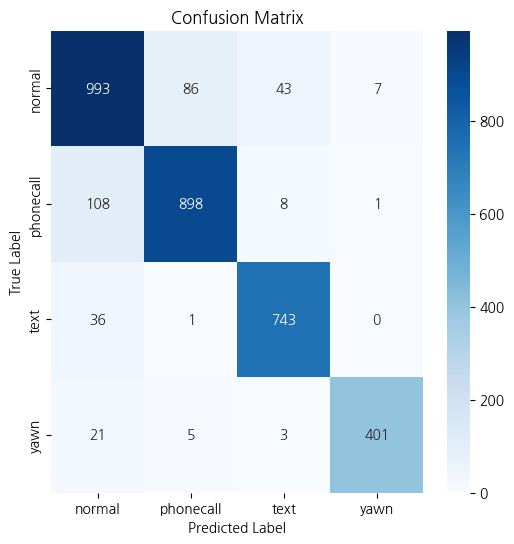


üîπ Classification Report:
              precision    recall  f1-score   support

      normal       0.86      0.88      0.87      1129
   phonecall       0.91      0.88      0.90      1015
        text       0.93      0.95      0.94       780
        yawn       0.98      0.93      0.96       430

    accuracy                           0.90      3354
   macro avg       0.92      0.91      0.92      3354
weighted avg       0.91      0.90      0.91      3354



In [112]:
model = load_model(model,"/content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/best_model_2025-03-17.pth", device)
class_names = config['action_names']
evaluate_model(model, train_loader, class_names, save_dir=config["train_result_path"], file_name="train")

‚úÖ Confusion Matrix saved at: /content/drive/MyDrive/DMS/data/model_results/031722_4s_sliding/train_results/test_cm.png


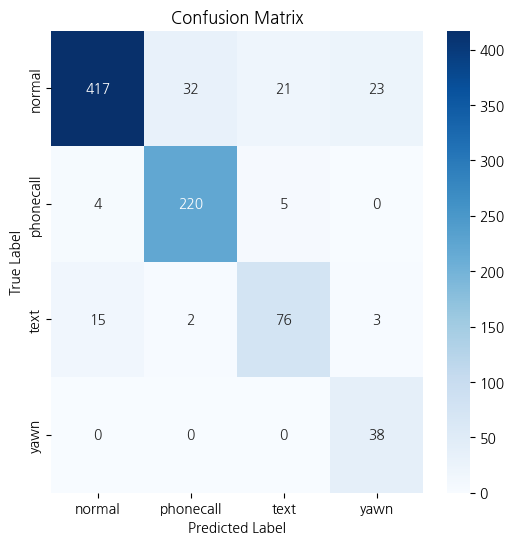


üîπ Classification Report:
              precision    recall  f1-score   support

      normal       0.96      0.85      0.90       493
   phonecall       0.87      0.96      0.91       229
        text       0.75      0.79      0.77        96
        yawn       0.59      1.00      0.75        38

    accuracy                           0.88       856
   macro avg       0.79      0.90      0.83       856
weighted avg       0.89      0.88      0.88       856



In [113]:
evaluate_model(model, test_loader, class_names, config["train_result_path"], "test")